In [3]:
import matplotlib.pyplot as plt

plt.annotate('[ProPublica https://www.propublica.org/datastore/dataset/amazon-pricing-algorithm-data-set]', (0,0),
             (-80,-20), fontsize=6, xycoords='axes fraction', textcoords='offset points', va='top')

Text(-80,-20,'[ProPublica https://www.propublica.org/datastore/dataset/amazon-pricing-algorithm-data-set]')

<a id="Legend"></a>
### Legend

- 250 bestselling products over several weeks
- For items that were listed without a shipping price, they were added to the shopping cart and proceeded to checkout where the shipping price was displayed 
- All of the items that lacked a shipping price were sold by Amazon or sellers in the “Fulfilled by Amazon” program
- Once shipping prices were compiled for all vendors, the price was re-calculated to combine price plus shipping for each item and re-ranked the items as they would have been ranked if shipping was included for all items
- For all products, sales tax was excluded from the analysis

<a id="Cleaning the Data"></a>
### Cleaning the Data

Initial Shape: 6,973 rows, 13 columns

BB (Buy Box) = The box on the product page where customers can begin the purchasing process by adding items to their carts. 


Amazon’s key feature is that multiple sellers can offer the same product, so during the end of the purchasing cycle the vendors can compete for the Buy Box for a particular product. Typically leads to increased sales. 


Ranking = Amazon’s price comparison ranking showing the lowest prices first 


REMEMBER: Scraped Price does not account for shipping if sold by Amazon or FBA (which makes deals on Amazon appear better than they are…) 
    

<a id="Hypothesis"></a>
### Hypothesis


Hypothesis: 
Amazon uses ‘dynamic pricing’ by increasing the retail cost of their products (surge pricing), which in turn online buyers do not actually receive a cheaper price through the site. Particularly for “Fulfilled by Amazon” products


**Approach:** 
    
Examining the Vendor Types to determine if pricing is more expensive than Retailers

1) Linear Regression Model 

2) Train/Test Split to subsample the data and create a model to help predict Amazon’s algorithmic pricing
   
    Manually Implement Bagged Decision Trees
    Reduce the variance by splitting and finding the average of the results


<a id="1) Cleaning and Observing the Data"></a>
### 1) Cleaning and Observing the Data

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [76]:
url = '/Users/ginaadduci/Desktop/git-repo-practice/final_project_amazon-ranking-analysis/data/09-19-Amazon-Ranking-Analysis.csv'

In [77]:
amazon = pd.read_csv(url, parse_dates = True, index_col='ScrapeDate')

In [78]:
amazon.head(10)

Index                                        ProductName  \
ScrapeDate                                                             
2016-06-14      0  #1 BEST Probiotic Supplement - 60 Day Supply w...   
2016-06-14      1  #1 BEST Probiotic Supplement - 60 Day Supply w...   
2016-06-27      2  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27      3  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27      4  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27      5  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27      6  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27      7  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27      8  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27      9  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   

            ScrapedIndex  ScrapedIndexTrueRank  CorrectedIndexTrueRank  \
ScrapeDate                                                               
2016-06-14             2                     2                       1   
2016-06-14             1                     1                       2   
2016-06-27             1                     1                       1   
2016-06-27             2                     1                       1   
2016-06-27             3                     1                       1   
2016-06-27            11                     9                       1   
2016-06-27             5                     3                       2   
2016-06-27             6                     4                       3   
2016-06-27             7                     5                       4   
2016-06-27             8                     6                       5   

            ScrapedIndexPrice  CorrectedPrice              ScrapedIndexVendor  \
ScrapeDate                                                                      
2016-06-14              20.99           20.99             Supplement Warriors   
2016-06-14              19.99           25.02                 Sharp Nutrition   
2016-06-27               3.96            3.96                    speedy tests   
2016-06-27               3.96            3.96              Drug Abuse Control   
2016-06-27               3.96            3.96             Lowest Priced Tests   
2016-06-27               3.96            3.96                    speedy tests   
2016-06-27               6.50            6.50                     Uritox, LLC   
2016-06-27               7.99            7.99                       mynewwhip   
2016-06-27               8.49            8.49                   ChopShopDeals   
2016-06-27               8.99            8.99  American Screening Corporation   

           ScrapedIndexVendorType  BBScrapedPrice BBVendorType  \
ScrapeDate                                                       
2016-06-14                  Other            -1.0          FBA   
2016-06-14                    FBA            -1.0          FBA   
2016-06-27                  Other             4.9          FBA   
2016-06-27                  Other             4.9          FBA   
2016-06-27                  Other             4.9          FBA   
2016-06-27                  Other             4.9          FBA   
2016-06-27                  Other             4.9          FBA   
2016-06-27                  Other             4.9          FBA   
2016-06-27                  Other             4.9          FBA   
2016-06-27                  Other             4.9          FBA   

                                                    BBVendor  BBCorrectedPrice  
ScrapeDate                                                                      
2016-06-14  Sold by Sharp Nutrition and Fulfilled by Amazon.             25.02  
2016-06-14  Sold by Sharp Nutrition and Fulfilled by Amazon.             25.02  
2016-06-27  Sold by Michael Minyety and Fulfilled by Amazon.              9.97  
2016-06-27  Sold by Michael Minyety and Fulfilled by Amazon.              9.97  
2016-0

In [79]:
amazon.tail(10)

Index               ProductName  ScrapedIndex  \
ScrapeDate                                                  
2016-08-30   6963  myBaby SoundSpa Portable             6   
2016-08-30   6964  myBaby SoundSpa Portable             7   
2016-08-30   6965  myBaby SoundSpa Portable             5   
2016-08-30   6966  myBaby SoundSpa Portable             9   
2016-08-30   6967  myBaby SoundSpa Portable            10   
2016-08-30   6968  myBaby SoundSpa Portable            11   
2016-08-30   6969  myBaby SoundSpa Portable            12   
2016-08-30   6970  myBaby SoundSpa Portable            13   
2016-08-30   6971  myBaby SoundSpa Portable             8   
2016-08-30   6972  myBaby SoundSpa Portable            14   

            ScrapedIndexTrueRank  CorrectedIndexTrueRank  ScrapedIndexPrice  \
ScrapeDate                                                                    
2016-08-30                     6                       5              28.36   
2016-08-30                     7                       6              31.11   
2016-08-30                     5                       7              25.20   
2016-08-30                     9                       8              32.89   
2016-08-30                    10                       9              33.72   
2016-08-30                    11                      10              34.14   
2016-08-30                    12                      11              34.98   
2016-08-30                    13                      12              35.00   
2016-08-30                     8                      13              31.95   
2016-08-30                    14                      14              39.99   

            CorrectedPrice            ScrapedIndexVendor  \
ScrapeDate                                                 
2016-08-30           28.36                    Happy Haus   
2016-08-30           31.11                      MINDeyes   
2016-08-30           31.98  Serenity Health & Home Decor   
2016-08-30           32.89                Aurora Store19   
2016-08-30           33.72            Tropicaltyphoonllc   
2016-08-30           34.14                       AMAZIN'   
2016-08-30           34.98                   Happy Titan   
2016-08-30           35.00                       DDN INC   
2016-08-30           38.73            Marilyn's Galleria   
2016-08-30           39.99             discount showcase   

           ScrapedIndexVendorType  BBScrapedPrice BBVendorType  \
ScrapeDate                                                       
2016-08-30                  Other           19.99       Amazon   
2016-08-30                  Other           19.99       Amazon   
2016-08-30                    FBA           19.99       Amazon   
2016-08-30                  Other           19.99       Amazon   
2016-08-30                  Other           19.99       Amazon   
2016-08-30                  Other           19.99       Amazon   
2016-08-30                  Other           19.99       Amazon   
2016-08-30                  Other           19.99       Amazon   
2016-08-30                    FBA           19.99       Amazon   
2016-08-30                  Other           19.99       Amazon   

                                      BBVendor  BBCorrectedPrice  
ScrapeDate                                                        
2016-08-30  Ships from and sold by Amazon.com.             26.77  
2016-08-30  Ships from and sold by Amazon.com.             26.77  
2016-08-30  Ships from and sold by Amazon.com.             26.77  
2016-08-30  Ships from and sold by Amazon.com.             26.77  
2016-08-30  Ships from and sold by Amazon.com.             26.77  
2016-08-30  Ships from and sold by Amazon.com.             26.77  
2016-08-30  Ships from and sold by Amazon.com.             26.77  
2016-08-30  Ships from and sold by Amazon.com.             26.77  
2016-08-30  Ships from and sold by Amazon.com.             26.77  
2016-08-30  Ships from and sold by Amazon.com.             26.77

Number of rows and columns

In [80]:
amazon.shape

(6973, 13)

6,973 vendor listings in total 

Types of data in columns

In [81]:
amazon.dtypes

Index                       int64
ProductName                object
ScrapedIndex                int64
ScrapedIndexTrueRank        int64
CorrectedIndexTrueRank      int64
ScrapedIndexPrice         float64
CorrectedPrice            float64
ScrapedIndexVendor         object
ScrapedIndexVendorType     object
BBScrapedPrice            float64
BBVendorType               object
BBVendor                   object
BBCorrectedPrice          float64
dtype: object

Column labels

In [82]:
amazon.columns

Index(['Index', 'ProductName', 'ScrapedIndex', 'ScrapedIndexTrueRank',
       'CorrectedIndexTrueRank', 'ScrapedIndexPrice', 'CorrectedPrice',
       'ScrapedIndexVendor', 'ScrapedIndexVendorType', 'BBScrapedPrice',
       'BBVendorType', 'BBVendor', 'BBCorrectedPrice'],
      dtype='object')

In [83]:
amazon.drop(['ScrapedIndex'], axis=1, inplace=True)

In [84]:
amazon.rename(columns={'ProductName':'product', 'ScrapedIndexTrueRank':'initial_rank',
                       'CorrectedIndexTrueRank': 'true_rank', 'ScrapedIndexPrice' : 'initial_price',
                       'CorrectedPrice':'true_price', 'ScrapedIndexVendor':'vendor',
                       'ScrapedIndexVendorType': 'initial_vendor_type', 'BBScrapedPrice':'buybox_initial_price',
                       'BBVendorType':'buybox_vendor_type', 'BBVendor':'buybox_vendor', 'BBCorrectedPrice' : 
                       'buybox_true_price'}, inplace =True)

In [85]:
amazon.columns

Index(['Index', 'product', 'initial_rank', 'true_rank', 'initial_price',
       'true_price', 'vendor', 'initial_vendor_type', 'buybox_initial_price',
       'buybox_vendor_type', 'buybox_vendor', 'buybox_true_price'],
      dtype='object')

Checking for missing data

In [86]:
amazon.isnull().sum()

Index                     0
product                   0
initial_rank              0
true_rank                 0
initial_price             0
true_price                0
vendor                    0
initial_vendor_type       0
buybox_initial_price      0
buybox_vendor_type        0
buybox_vendor           164
buybox_true_price         0
dtype: int64

Dropped missing vendors

In [87]:
amazon.dropna(inplace = True)

In [88]:
amazon.isnull().sum()

Index                   0
product                 0
initial_rank            0
true_rank               0
initial_price           0
true_price              0
vendor                  0
initial_vendor_type     0
buybox_initial_price    0
buybox_vendor_type      0
buybox_vendor           0
buybox_true_price       0
dtype: int64

<a id='Steps to Clean Data'></a>
### Steps to Clean Data

Dropped Scraped Index Ranking
Dropped Null Values (164 within Buy Box Vendor) 
Renamed Column Names 
Converted BuyBox Vendor Type and Initial Buy Box Vendor Type into 3 numerical values : 
1: Amazon
2: FBA (Fulfilled by Amazon)
0: Other
Converted Negative Prices to 0

…Later dropped Product, Buy Box Vendor for Manual Bagged Decision Tree

<a id='2) Tested True Rank Versus Initial Rank'></a>
### 2) Tested True Rank Versus Initial Rank

- Once shipping prices were compiled for all vendors, the price was re-calculated to combine price plus shipping for each item and re-ranked the items as they would have been ranked if shipping was included for all items

**Hypothesis**: Amazon products were ranked higher for the Initial Rank

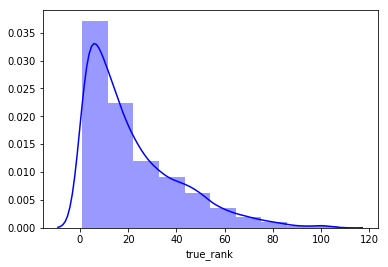

In [17]:
true_rank = amazon.loc[:, 'true_rank']
sns.distplot(true_rank, bins=10, color='b');

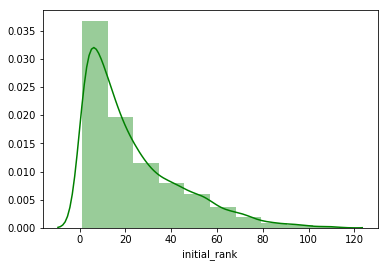

In [18]:
initial_rank = amazon.loc[:, 'initial_rank']
sns.distplot(initial_rank, bins=10, color='g');

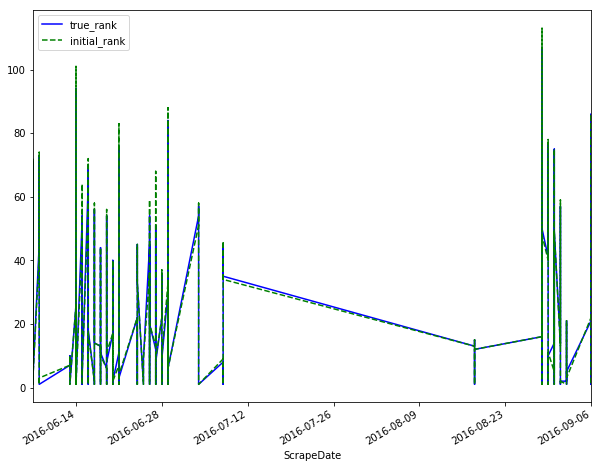

In [19]:
amazon.loc[:, ('true_rank', 'initial_rank')].plot(figsize=(10,8), 
                                                  style={'true_rank': 'b', 'initial_rank': '--g'});

In [20]:
amazon.buybox_vendor_type.unique()

array(['FBA', 'O', 'Amazon'], dtype=object)

In [21]:
buybox_vendor_type_o_replace = {'Amazon':'amazon','O':'other','FBA':'fba'}
amazon['buybox_vendor_type'].replace(buybox_vendor_type_o_replace, inplace = True)

/Users/ginaadduci/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


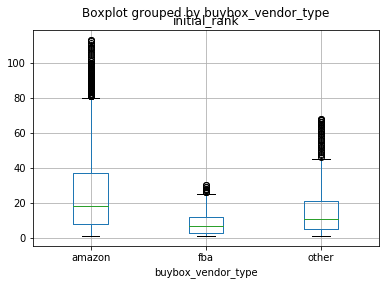

In [22]:
amazon.boxplot('initial_rank', 'buybox_vendor_type');

/Users/ginaadduci/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


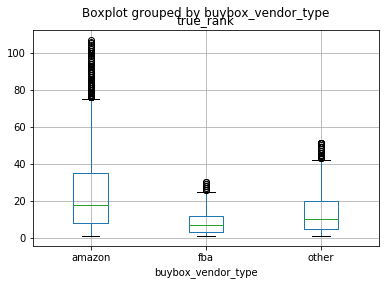

In [23]:
amazon.boxplot('true_rank', 'buybox_vendor_type');

In [24]:
amazon.true_rank.mean()

21.727125862828608

In [25]:
amazon.initial_rank.mean()

22.91202819797327

<a id='3) Buy Box Vendor Type adn Price'></a>
### 3) Buy Box Vendor Type and Price

Buy Box Vendor Type and Price
Once shipping prices were compiled for all vendors, the price was re-calculated to combine price plus shipping for each item and re-ranked the items as they would have been ranked if shipping was included for all items

Hypothesis: Amazon and FBA products were actually more expensive than Amazon leads users to believe

In [26]:
amazon.loc[:, 'buybox_vendor_type'].value_counts()

amazon    5788
other      551
fba        470
Name: buybox_vendor_type, dtype: int64

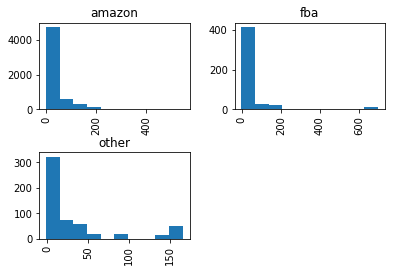

In [27]:
amazon.hist('buybox_initial_price', 'buybox_vendor_type'); 

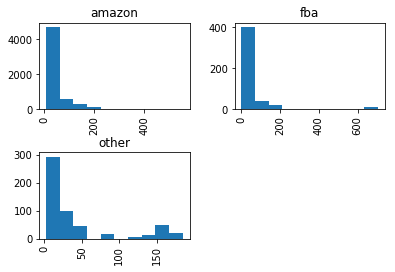

In [28]:
amazon.hist('buybox_true_price', 'buybox_vendor_type');

**Analysis Results**: Analysis shows that Amazon places their products in the "Buy Box" section during the customer's user journey, even when 'Other' had cheaper products


Graphs are highly skewed

<a id='3) True Price Initial Price'></a>
### 3) True Price Versus Initial Price

- Once shipping prices were compiled for all vendors, the price was re-calculated to combine price plus shipping for each item and re-ranked the items as they would have been ranked if shipping was included for all items

**Hypothesis**: Amazon and FBA products were placed higher in ranking order, but were more expensive

In [29]:
amazon.buybox_initial_price.mean()

37.194115141723124

In [30]:
amazon.buybox_true_price.mean()

45.87530621236549

In [31]:
amazon.groupby('buybox_vendor_type').mean()

Index  initial_rank  true_rank  initial_price  \
buybox_vendor_type                                                        
amazon              3411.141500     24.728058  23.488079      55.407719   
fba                 4313.157447      8.763830   8.685106      53.358319   
other               3575.094374     15.903811  14.353902      56.455771   

                    true_price  buybox_initial_price  buybox_true_price  
buybox_vendor_type                                                       
amazon               56.010788             37.481282          46.031356  
fba                  54.893447             36.571553          46.602383  
other                57.006770             34.708603          43.615880

<a id='4) True Price Versus True Rank - Testing Product'></a>
### 4) True Price Versus True Rank - Testing Product

In [109]:
product_group = amazon[amazon.groupby('product')['product'].transform('size')>20]

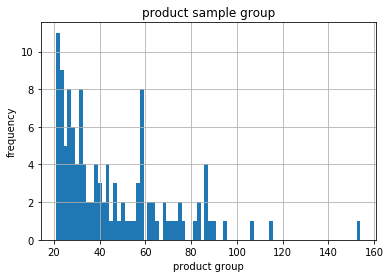

In [112]:
product_group['product'].value_counts().hist(bins=80)
plt.xlabel('product group')
plt.ylabel('frequency')
plt.title('product sample group');

<a id='Understanding the Data'></a>
### Understanding the Data 

**Additional Data Pulls**

In [32]:
amazon.loc[:, 'product'].value_counts()

Fujifilm INSTAX Mini Instant Film (Rainbow)                                                                                                                                                        154
Suncast GHW1732 Resin Wicker Trash Hideaway                                                                                                                                                        115
Fiskars 45mm Contour Rotary Cutter (195210-1001)                                                                                                                                                   106
K&N 99-5000 Aerosol Recharger Filter Care Service Kit                                                                                                                                               95
Honeywell HT-908 Turbo Force Room Air Circulator Fan                                                                                                                                                90
Sassy

In [33]:
amazon.buybox_vendor.unique()

array(['Sold by Sharp Nutrition and Fulfilled by Amazon.',
       'Sold by Michael Minyety and Fulfilled by Amazon.',
       'Ships from and sold by Happy DRH.',
       'Ships from and sold by Solutions Pest & Lawn.',
       'Ships from and sold by Amazon.com.',
       'Ships from and sold by Adams Brown Company.',
       'Ships from and sold by Amazon.com in easy-to-open packaging.',
       'Ships from and sold by Cell Emporium.',
       'Sold by Art Naturals and Fulfilled by Amazon.',
       'Sold by LuckyLuckyLucky and Fulfilled by Amazon.',
       'Sold by Radha Beauty Products and Fulfilled by Amazon.',
       'Ships from and sold by PORTABLE GUY.',
       'Ships from and sold by Focus Camera.',
       'Ships from and sold by Brookstone.',
       'Sold by Finelane, USA and Fulfilled by Amazon.',
       'Sold by dizzy deals and Fulfilled by Amazon.',
       'Sold by Cabinet Hardware 4 Less and Fulfilled by Amazon.',
       'Sold by TabletExpress and Fulfilled by Amazon.',
       'S

In [34]:
Vendor_Shipment_Uniques = pd.value_counts(amazon['buybox_vendor'].values)
Vendor_Shipment_Uniques

Ships from and sold by Amazon.com.                                      5293
Ships from and sold by Amazon.com in easy-to-open packaging.             495
Ships from and sold by El Garaje.                                         86
Ships from and sold by PORTABLE GUY.                                      46
Ships from and sold by ShopChanute.                                       44
Ships from and sold by HE TAO.                                            39
Sold by Beauty Base and Fulfilled by Amazon.                              39
Sold by CHENGFENGPOLANG and Fulfilled by Amazon.                          32
Sold by XoomBot and Fulfilled by Amazon.                                  32
Ships from and sold by Gatzies.                                           28
Ships from and sold by samselectro in easy-to-open packaging.             26
Ships from and sold by Imagine Toys!.                                     26
Sold by Deals On Call and Fulfilled by Amazon.                            26

In [35]:
amazon.vendor.value_counts()

Amazon.com                                                           192
UnbeatableSale, Inc                                                   46
Gatzies                                                               38
DDN INC                                                               37
DropAir                                                               34
MINDeyes                                                              34
V1-Store                                                              33
Toys US                                                               33
ShopChanute                                                           32
MeagaDeal                                                             30
XoXoGroupLLC                                                          29
TheNewMall                                                            28
Mild Shop                                                             27
Happy Titan                                        

In [36]:
amazon.columns

Index(['Index', 'product', 'initial_rank', 'true_rank', 'initial_price',
       'true_price', 'vendor', 'initial_vendor_type', 'buybox_initial_price',
       'buybox_vendor_type', 'buybox_vendor', 'buybox_true_price'],
      dtype='object')

In [37]:
Demo = ['buybox_vendor_type', 'initial_rank', 'true_rank']

amazon_demo = amazon.sort_values('buybox_vendor_type', ascending = True)
amazon_demo.groupby('buybox_vendor_type').head(10)[Demo]

buybox_vendor_type  initial_rank  true_rank
ScrapeDate                                            
2016-06-29             amazon             9          8
2016-09-02             amazon             7          4
2016-09-02             amazon             6          3
2016-09-02             amazon             5          2
2016-09-02             amazon             4          1
2016-09-01             amazon            57         57
2016-09-01             amazon            56         56
2016-09-01             amazon            59         55
2016-09-01             amazon            55         54
2016-09-01             amazon            50         53
2016-06-26                fba            10         11
2016-06-26                fba            14         15
2016-06-26                fba            13         14
2016-06-26                fba            12         13
2016-06-26                fba            11         12
2016-06-26                fba            15         16
2016-06-26                fba            17         17
2016-06-26                fba             2          1
2016-06-21                fba             1          1
2016-06-27                fba             7          9
2016-06-27              other            38         19
2016-06-27              other            18         19
2016-06-27              other            17         18
2016-06-27              other            16         17
2016-06-27              other            15         16
2016-06-27              other            37         15
2016-06-27              other            14         14
2016-06-27              other            13         13
2016-06-27              other            45         19
2016-06-27              other            12         12

In [38]:
Demo = ['buybox_vendor_type', 'initial_rank', 'true_rank']

amazon_demo = amazon.sort_values('true_rank', ascending = True)
amazon_demo.groupby('true_rank').head(10)[Demo]

buybox_vendor_type  initial_rank  true_rank
ScrapeDate                                            
2016-06-14                fba             2          1
2016-08-30             amazon             2          1
2016-07-08                fba             2          1
2016-06-26                fba             1          1
2016-06-29             amazon             1          1
2016-06-21             amazon             1          1
2016-06-27             amazon             1          1
2016-06-29             amazon             1          1
2016-06-14                fba             1          1
2016-06-16             amazon             2          1
2016-06-27              other             2          2
2016-06-21             amazon             3          2
2016-06-16              other             2          2
2016-06-14             amazon             4          2
2016-09-01             amazon             2          2
2016-06-20                fba             2          2
2016-06-28             amazon             4          2
2016-06-26             amazon             2          2
2016-06-14             amazon             3          2
2016-06-27                fba             4          2
2016-09-06             amazon             5          3
2016-09-02             amazon             5          3
2016-06-27             amazon             3          3
2016-09-06             amazon             4          3
2016-06-14             amazon             5          3
2016-06-07             amazon             4          3
2016-08-29             amazon             7          3
2016-09-02             amazon             4          3
2016-06-14             amazon             5          3
2016-06-14             amazon             4          3
...                       ...           ...        ...
2016-08-29             amazon            87         93
2016-08-29             amazon            87         93
2016-06-14             amazon            86         93
2016-08-29             amazon            87         93
2016-06-14             amazon            87         94
2016-08-29             amazon           111         94
2016-08-29             amazon            88         95
2016-08-29             amazon            89         96
2016-08-29             amazon            90         97
2016-08-29             amazon            91         98
2016-08-29             amazon            92         99
2016-08-29             amazon            93        100
2016-08-29             amazon            93        100
2016-08-29             amazon            93        100
2016-08-29             amazon            93        100
2016-08-29             amazon            93        100
2016-08-29             amazon            93        100
2016-08-29             amazon            93        100
2016-08-29             amazon            93        100
2016-08-29             amazon            93        100
2016-08-29             amazon            93        100
2016-08-29             amazon            94        101
2016-08-29             amazon            94        101
2016-08-29             amazon            94        101
2016-08-29             amazon           112        102
2016-08-29             amazon            95        103
2016-08-29             amazon            96        104
2016-08-29             amazon            97        105
2016-08-29             amazon            98        106
2016-08-29             amazon            99        107

[869 rows x 3 columns]

<a id="Data Analysis"></a>
### Data Analysis

In [39]:
amazon.columns

Index(['Index', 'product', 'initial_rank', 'true_rank', 'initial_price',
       'true_price', 'vendor', 'initial_vendor_type', 'buybox_initial_price',
       'buybox_vendor_type', 'buybox_vendor', 'buybox_true_price'],
      dtype='object')

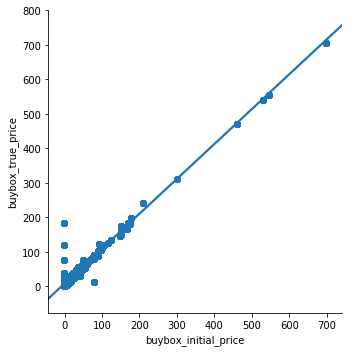

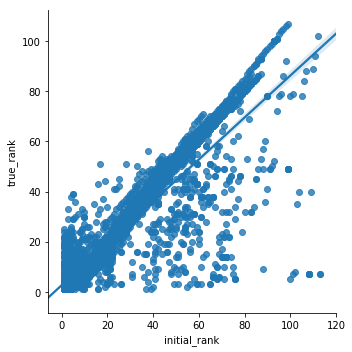

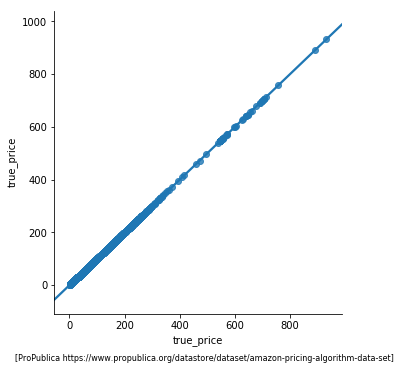

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

sns.lmplot(x='buybox_initial_price', y='buybox_true_price', data=amazon)
plt.show()
sns.lmplot(x='initial_rank', y='true_rank', data=amazon)
plt.show()
sns.lmplot(x='true_price', y='true_price', data=amazon);

plt.annotate('[ProPublica https://www.propublica.org/datastore/dataset/amazon-pricing-algorithm-data-set]', 
             (-0.1,-0.1),
(-10,-10), fontsize=8, xycoords='axes fraction', textcoords='offset points', va='top');

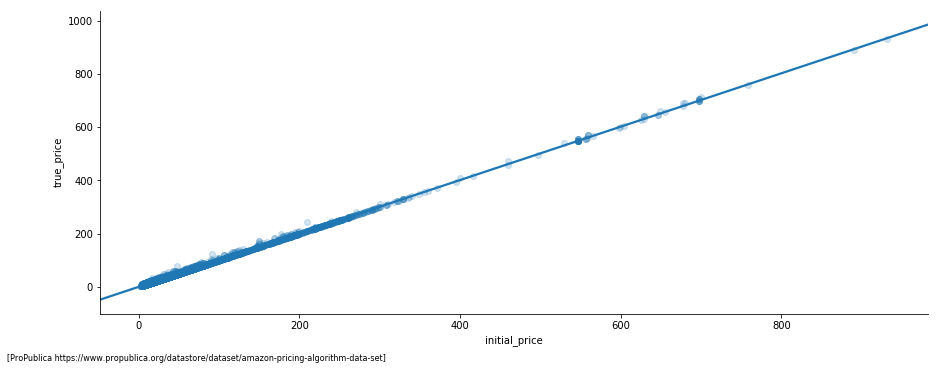

In [41]:
sns.lmplot(x = 'initial_price', 
           y = 'true_price', 
           data = amazon,
           aspect = 2.5,
           scatter_kws = {'alpha' : 0.2}
          );
plt.annotate('[ProPublica https://www.propublica.org/datastore/dataset/amazon-pricing-algorithm-data-set]', 
             (-0.1,-0.1), (-10,-10), fontsize=8, xycoords='axes fraction', textcoords='offset points', va='top');

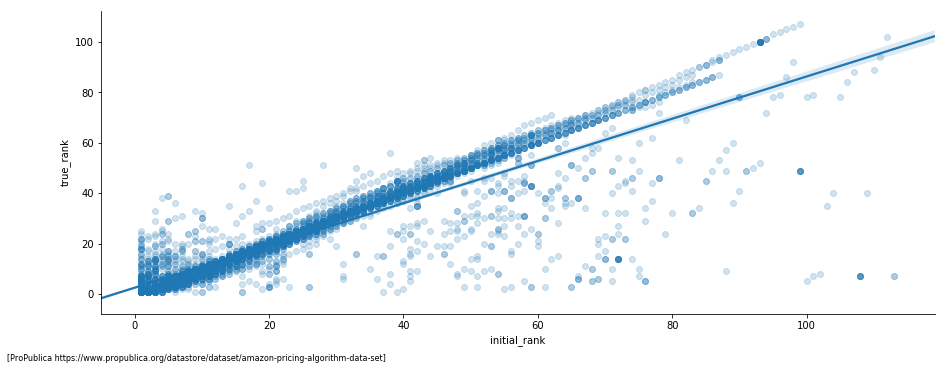

In [42]:
sns.lmplot(x = 'initial_rank', 
           y = 'true_rank', 
           data = amazon,
           aspect = 2.5,
           scatter_kws = {'alpha' : 0.2}
          );

plt.annotate('[ProPublica https://www.propublica.org/datastore/dataset/amazon-pricing-algorithm-data-set]', 
             (-0.1,-0.1), (-10,-10), fontsize=8, xycoords='axes fraction', textcoords='offset points', va='top');

In [43]:
amazon.loc[:, ['initial_rank', 'true_rank']].describe()

initial_rank    true_rank
count   6809.000000  6809.000000
mean      22.912028    21.727126
std       20.654729    19.283459
min        1.000000     1.000000
25%        7.000000     7.000000
50%       16.000000    16.000000
75%       33.000000    32.000000
max      113.000000   107.000000

In [44]:
amazon.loc[:, ['initial_rank', 'true_rank']].describe()

initial_rank    true_rank
count   6809.000000  6809.000000
mean      22.912028    21.727126
std       20.654729    19.283459
min        1.000000     1.000000
25%        7.000000     7.000000
50%       16.000000    16.000000
75%       33.000000    32.000000
max      113.000000   107.000000

In [45]:
amazon.loc[:, ['buybox_true_price', 'buybox_initial_price']].describe()

buybox_true_price  buybox_initial_price
count        6809.000000           6809.000000
mean           45.875306             37.194115
std            64.219256             62.303672
min             0.000000             -1.000000
25%            15.780000              9.760000
50%            23.980000             15.990000
75%            47.920000             37.040000
max           706.110000            698.000000

In [46]:
amazon.loc[:, ['buybox_true_price', 'true_price']].describe()

buybox_true_price   true_price
count        6809.000000  6809.000000
mean           45.875306    56.014259
std            64.219256    75.227399
min             0.000000     2.380000
25%            15.780000    19.990000
50%            23.980000    32.130000
75%            47.920000    56.330000
max           706.110000   931.800000

In [47]:
# Correlation calculation 
amazon.loc[:,['initial_rank','true_rank', 'initial_price', 'true_price',
                    'buybox_vendor_type', 'buybox_initial_price', 'buybox_true_price']].corr()

initial_rank  true_rank  initial_price  true_price  \
initial_rank              1.000000   0.897077       0.032231    0.024696   
true_rank                 0.897077   1.000000       0.045485    0.040448   
initial_price             0.032231   0.045485       1.000000    0.999518   
true_price                0.024696   0.040448       0.999518    1.000000   
buybox_initial_price     -0.054699  -0.052992       0.950974    0.952252   
buybox_true_price        -0.058678  -0.056991       0.973103    0.974275   

                      buybox_initial_price  buybox_true_price  
initial_rank                     -0.054699          -0.058678  
true_rank                        -0.052992          -0.056991  
initial_price                     0.950974           0.973103  
true_price                        0.952252           0.974275  
buybox_initial_price              1.000000           0.980706  
buybox_true_price                 0.980706           1.000000

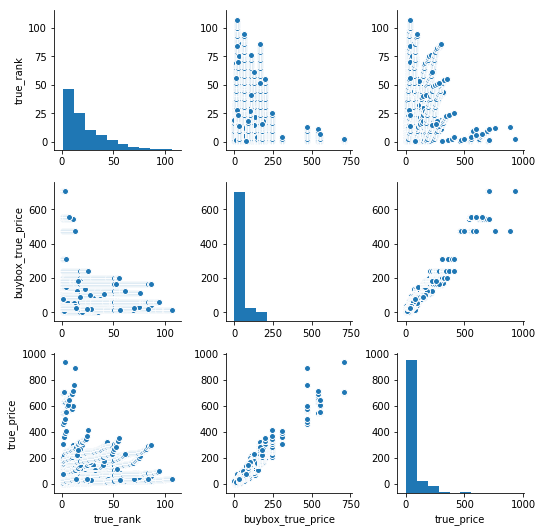

In [48]:
sns.pairplot(amazon, vars=['true_rank', 'buybox_true_price', 'true_price']);

Appears to be a correlation between True Price & True Rank

In [49]:
amazon.loc[:, 'product'].value_counts()

Fujifilm INSTAX Mini Instant Film (Rainbow)                                                                                                                                                        154
Suncast GHW1732 Resin Wicker Trash Hideaway                                                                                                                                                        115
Fiskars 45mm Contour Rotary Cutter (195210-1001)                                                                                                                                                   106
K&N 99-5000 Aerosol Recharger Filter Care Service Kit                                                                                                                                               95
Honeywell HT-908 Turbo Force Room Air Circulator Fan                                                                                                                                                90
Sassy

In [50]:
amazon.loc[:, 'buybox_vendor'].value_counts()

Ships from and sold by Amazon.com.                                      5293
Ships from and sold by Amazon.com in easy-to-open packaging.             495
Ships from and sold by El Garaje.                                         86
Ships from and sold by PORTABLE GUY.                                      46
Ships from and sold by ShopChanute.                                       44
Ships from and sold by HE TAO.                                            39
Sold by Beauty Base and Fulfilled by Amazon.                              39
Sold by CHENGFENGPOLANG and Fulfilled by Amazon.                          32
Sold by XoomBot and Fulfilled by Amazon.                                  32
Ships from and sold by Gatzies.                                           28
Ships from and sold by samselectro in easy-to-open packaging.             26
Ships from and sold by Imagine Toys!.                                     26
Sold by Deals On Call and Fulfilled by Amazon.                            26

<a id="Splitting Data into 2"></a>
### Splitting Data into 2 Universes

In [254]:
amazon.columns

Index(['Index', 'initial_rank', 'true_rank', 'initial_price', 'true_price',
       'buybox_initial_price', 'buybox_true_price', 'bb_vtype',
       'bb_type_initial'],
      dtype='object')

In [282]:
amazon.loc[:, 'buybox_initial_price'].value_counts().tail()

77.30    2
92.99    2
6.30     2
71.00    2
69.99    2
Name: buybox_initial_price, dtype: int64

In [283]:
amazon_demo = amazon.sort_values('buybox_initial_price', ascending = True)
amazon_demo

Index  initial_rank  true_rank  initial_price  true_price  \
ScrapeDate                                                              
2016-06-14      0             2          1          20.99       20.99   
2016-09-06   5779            13         13          29.98       29.98   
2016-09-06   5780            14         14          29.99       29.99   
2016-09-06   5781            14         14          29.99       29.99   
2016-09-06   5782            15         15          30.80       30.80   
2016-09-06   5783            16         16          30.99       30.99   
2016-09-06   5784            17         17          31.00       31.00   
2016-09-06   5785            18         18          32.22       32.22   
2016-09-06   5786            19         19          32.30       32.30   
2016-09-06   5787            20         20          32.46       32.46   
2016-09-06   5788            21         21          32.48       32.48   
2016-09-06   5789            21         21          32.48       32.48   
2016-06-21    739             7          7          39.99       39.99   
2016-06-21    738             6          6          28.99       28.99   
2016-09-06   5778            12         12          29.90       29.90   
2016-06-21    737             5          5          28.95       28.95   
2016-06-21    735             3          3          27.59       27.59   
2016-06-21    734             2          2          24.95       24.95   
2016-06-21    733             2          2          24.95       24.95   
2016-06-21    732             1          1          14.95       20.43   
2016-06-27    706            18         17          32.97       38.45   
2016-06-27    705            17         16          31.99       31.99   
2016-06-27    704            15         15          30.99       30.99   
2016-06-27    703            14         14          29.99       29.99   
2016-06-27    702            13         13          29.97       29.97   
2016-06-27    701            12         12          28.95       28.95   
2016-06-27    700            11         11          28.00       28.00   
2016-06-27    699            10         10          24.95       24.95   
2016-06-27    698            10         10          24.95       24.95   
2016-06-21    736             4          4          28.85       28.85   
...           ...           ...        ...            ...         ...   
2016-07-08    382             8          9         678.12      689.95   
2016-08-30   4958             2          1         546.95      546.95   
2016-08-30   4959             2          1         546.95      546.95   
2016-08-30   4977             7          7         646.95      646.95   
2016-08-30   4976             6          6         603.70      603.70   
2016-08-30   4975             5          5         599.00      599.00   
2016-08-30   4974             4          4         555.40      555.40   
2016-08-30   4973             1          3         546.95      553.97   
2016-08-30   4971             1          3         546.95      553.97   
2016-08-30   4970             1          3         546.95      553.97   
2016-08-30   4969             3          2         546.99      546.99   
2016-08-30   4972             1          3         546.95      553.97   
2016-08-30   4967             2          1         546.95      546.95   
2016-08-30   4968             2          1         546.95      546.95   
2016-08-30   4961             2          1         546.95      546.95   
2016-08-30   4962             2          1         546.95      546.95   
2016-08-30   4963             2          1         546.95      546.95   
2016-08-30   4960             2          1         546.95      546.95   
2016-08-30   4965             2          1         546.95      546.95   
2016-08-30   4966             2          1         546.95      546.95   
2016-08-30   4964             2          1         546.95      546.95   
2016-08-30   6285             3          3         931.80      931.80 

In [64]:
# Read in and prepare the vehicle testing data.
url = '/Users/ginaadduci/Desktop/git-repo-practice/final_project_amazon-ranking-analysis/data/09-19-Amazon-Ranking-Analysis.csv'
test1 = pd.read_csv(url)

In [65]:
test1.columns

Index(['Index', 'ProductName', 'ScrapeDate', 'ScrapedIndex',
       'ScrapedIndexTrueRank', 'CorrectedIndexTrueRank', 'ScrapedIndexPrice',
       'CorrectedPrice', 'ScrapedIndexVendor', 'ScrapedIndexVendorType',
       'BBScrapedPrice', 'BBVendorType', 'BBVendor', 'BBCorrectedPrice'],
      dtype='object')

In [66]:
test1.rename(columns={'ScrapedIndexTrueRank':'initial_rank',
                       'CorrectedIndexTrueRank': 'true_rank', 'ScrapedIndexPrice' : 'initial_price',
                       'CorrectedPrice':'true_price','BBScrapedPrice':'buybox_initial_price',
                        'BBCorrectedPrice' : 'buybox_true_price'}, inplace =True)

In [67]:
test1.isnull().sum()

Index                       0
ProductName                 0
ScrapeDate                  0
ScrapedIndex                0
initial_rank                0
true_rank                   0
initial_price               0
true_price                  0
ScrapedIndexVendor          0
ScrapedIndexVendorType      0
buybox_initial_price        0
BBVendorType                0
BBVendor                  164
buybox_true_price           0
dtype: int64

In [68]:
test1.dropna(inplace = True)

In [69]:
test1.columns

Index(['Index', 'ProductName', 'ScrapeDate', 'ScrapedIndex', 'initial_rank',
       'true_rank', 'initial_price', 'true_price', 'ScrapedIndexVendor',
       'ScrapedIndexVendorType', 'buybox_initial_price', 'BBVendorType',
       'BBVendor', 'buybox_true_price'],
      dtype='object')

In [62]:
test1.drop(['ScrapedIndex', 'ProductName', 'ScrapedIndexVendor', 'BBVendor', 'ScrapeDate'], axis=1, inplace=True)

ValueError: labels ['ScrapedIndex' 'ProductName' 'ScrapedIndexVendor' 'BBVendor' 'ScrapeDate'] not contained in axis

In [63]:
test1.rename(columns={'ScrapedIndexTrueRank':'initial_rank',
                       'CorrectedIndexTrueRank': 'true_rank', 'ScrapedIndexPrice' : 'initial_price',
                       'CorrectedPrice':'true_price','BBScrapedPrice':'buybox_initial_price',
                        'BBCorrectedPrice' : 'buybox_true_price'}, inplace =True)

/Users/ginaadduci/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [29]:
test1.columns

Index(['Index', 'initial_rank', 'true_rank', 'initial_price', 'true_price',
       'ScrapedIndexVendorType', 'buybox_initial_price', 'BBVendorType',
       'buybox_true_price'],
      dtype='object')

In [30]:
#Price includes negative numbers. To ensure data is not skewed, I replaced negative with 0. 
test1.loc[:,'buybox_initial_price'].replace([-1],0, inplace=True)
test1.loc[:,'initial_price'].replace([-1],0, inplace=True)

In [31]:
test1.head()

Index  initial_rank  true_rank  initial_price  true_price  \
0      0             2          1          20.99       20.99   
1      1             1          2          19.99       25.02   
2      2             1          1           3.96        3.96   
3      3             1          1           3.96        3.96   
4      4             1          1           3.96        3.96   

  ScrapedIndexVendorType  buybox_initial_price BBVendorType  buybox_true_price  
0                  Other                   0.0          FBA              25.02  
1                    FBA                   0.0          FBA              25.02  
2                  Other                   4.9          FBA               9.97  
3                  Other                   4.9          FBA               9.97  
4                  Other                   4.9          FBA               9.97

In [32]:
# Transform "buybox_vendor_type" 
test1.loc[:, 'bb_vtype'] = test1.loc[:, 'BBVendorType'].map({'Amazon': 1, 'O': 3, 'FBA': 2})
test1.drop('BBVendorType', axis=1, inplace=True)
test1.loc[:, 'bb_type_initial'] = test1.loc[:, 'ScrapedIndexVendorType'].map({'Amazon': 1, 'O': 3, 'FBA': 2})
test1.drop('ScrapedIndexVendorType', axis=1, inplace=True)
test1

Index  initial_rank  true_rank  initial_price  true_price  \
0         0             2          1          20.99       20.99   
1         1             1          2          19.99       25.02   
2         2             1          1           3.96        3.96   
3         3             1          1           3.96        3.96   
4         4             1          1           3.96        3.96   
5         5             9          1           3.96        3.96   
6         6             3          2           6.50        6.50   
7         7             4          3           7.99        7.99   
8         8             5          4           8.49        8.49   
9         9             6          5           8.99        8.99   
10       10            11          6           9.04        9.04   
11       11            10          7           4.79        9.86   
12       12             2          8           4.90        9.97   
13       13             7          9           9.99        9.99   
14       14             8         10          10.00       10.00   
15       15            12         11          14.48       14.48   
16       16            12         11          14.48       14.48   
17       17            13         12          33.54       33.54   
18       18            14         13          35.49       35.49   
19       19             1          1          40.00       40.00   
20       20             2          2          54.94       54.94   
21       21             1          1           6.79        6.79   
22       22             3          2           8.97        8.97   
23       23             4          3          12.48       12.48   
24       24             5          4          13.89       13.89   
25       25             7          5          14.68       14.68   
26       26             8          6          14.99       14.99   
27       27             2          7           8.97       15.54   
28       28             2          7           8.97       15.54   
29       29             6          8          14.00       20.57   
...     ...           ...        ...            ...         ...   
6943   6943            18         18          28.95       28.95   
6944   6944            19         19          29.86       29.86   
6945   6945            20         20          29.95       29.95   
6946   6946            22         20          29.95       29.95   
6947   6947            22         20          29.95       29.95   
6948   6948            22         20          29.95       29.95   
6949   6949            22         20          29.95       29.95   
6950   6950            22         20          29.95       29.95   
6951   6951            22         20          29.95       29.95   
6952   6952            25         20          29.95       29.95   
6953   6953            26         21          29.97       29.97   
6954   6954            23         22          33.97       33.97   
6955   6955            27         23          34.97       34.97   
6956   6956            24         24          38.98       38.98   
6957   6957             2          1           8.99        8.99   
6958   6958             1          2           7.98       13.97   
6959   6959             2          1          19.99       19.99   
6960   6960             3          2          23.44       23.44   
6961   6961             4          3          24.49       24.49   
6962   6962             1          4          19.99       26.77   
6963   6963             6          5          28.36       28.36   
6964   6964             7          6          31.11       31.11   
6965   6965             5          7          25.20       31.98   
6966   6966             9          8          32.89       32.89   
6967   6967            10          9          33.72       33.72   
6968   6968            11         10          34.14       34.14   
6969   6969            12         11          34.98       34.98   
6970   6970            13         12          35.00  

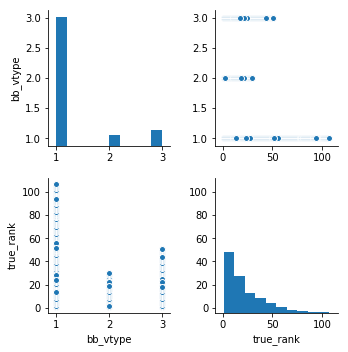

In [33]:
sns.pairplot(test1, vars=['bb_vtype', 'true_rank']);

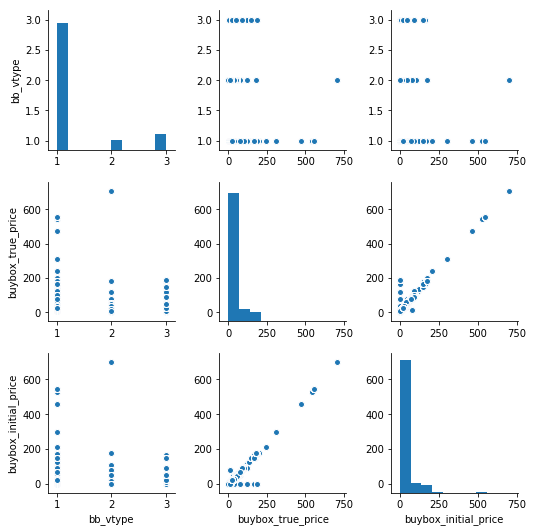

In [270]:
sns.pairplot(test1, vars=['bb_vtype', 'buybox_true_price', 'buybox_initial_price']);

In [271]:
test1.describe()

Index  initial_rank    true_rank  initial_price   true_price  \
count  6973.000000   6973.000000  6973.000000    6973.000000  6973.000000   
mean   3486.000000     22.730962    21.559300      54.904896    55.567631   
std    2013.076046     20.520442    19.154709      74.293356    74.476092   
min       0.000000      1.000000     1.000000       2.380000     2.380000   
25%    1743.000000      7.000000     7.000000      19.530000    20.010000   
50%    3486.000000     16.000000    16.000000      31.900000    32.080000   
75%    5229.000000     33.000000    31.000000      55.890000    56.100000   
max    6972.000000    113.000000   107.000000     931.800000   931.800000   

       buybox_initial_price  buybox_true_price     bb_vtype  bb_type_initial  
count           6973.000000        6973.000000  6973.000000       601.000000  
mean              36.347158          45.827961     1.272480         1.680532  
std               61.807480          63.889925     0.635113         0.466659  
min                0.000000           0.000000     1.000000         1.000000  
25%                8.990000          15.790000     1.000000         1.000000  
50%               14.940000          23.340000     1.000000         2.000000  
75%               36.990000          47.920000     1.000000         2.000000  
max              698.000000         706.110000     3.000000         2.000000

In [34]:
test1.isnull().sum()

Index                      0
initial_rank               0
true_rank                  0
initial_price              0
true_price                 0
buybox_initial_price       0
buybox_true_price          0
bb_vtype                   0
bb_type_initial         6372
dtype: int64

In [35]:
test1.loc[:, 'buybox_true_price'] > 100

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
6943    False
6944    False
6945    False
6946    False
6947    False
6948    False
6949    False
6950    False
6951    False
6952    False
6953    False
6954    False
6955    False
6956    False
6957    False
6958    False
6959    False
6960    False
6961    False
6962    False
6963    False
6964    False
6965    False
6966    False
6967    False
6968    False
6969    False
6970    False
6971    False
6972    False
Name: buybox_true_price, Length: 6973, dtype: bool

In [36]:
test1 = test1.loc[test1.loc[:, 'buybox_true_price'] > 100, :]
test1.shape

(830, 9)

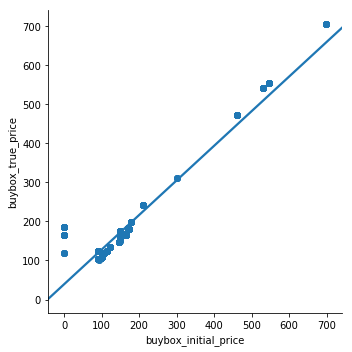

In [37]:
sns.lmplot(x='buybox_initial_price', y='buybox_true_price', data=test1, ci=None); #CI = Confidence Intervals

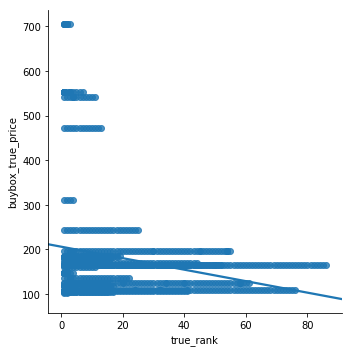

In [38]:
sns.lmplot(x='true_rank', y='buybox_true_price', data=test1, ci=None); #CI = Confidence Intervals

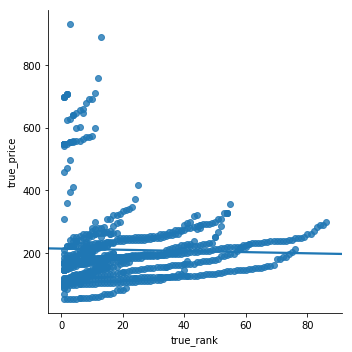

In [39]:
sns.lmplot(x='true_rank', y='true_price', data=test1, ci=None); #CI = Confidence Intervals

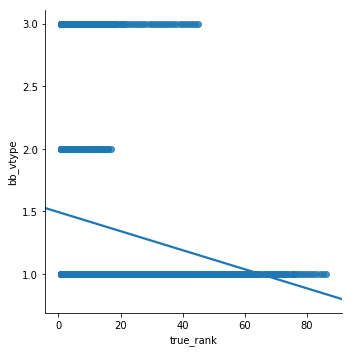

In [40]:
sns.lmplot(x='true_rank', y='bb_vtype', data=test1, ci=None);

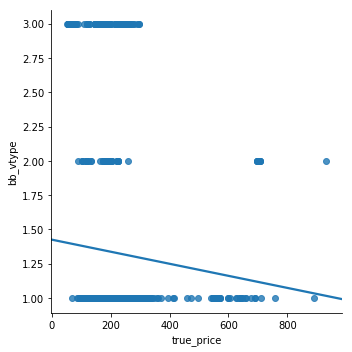

In [41]:
sns.lmplot(x='true_price', y='bb_vtype', data=test1, ci=None);

<a id="Linear Regression Model - Price vs Rank"></a>
### Linear Regression Model - Price vs Rank

In [48]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [49]:
# Make an instance of the LinearRegression class.
LinearRegression()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [50]:
# Train the model instance on our data, using just temp_celsius for now
lr_rankprice=LinearRegression()
lr_rankprice

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [51]:
# Add the fitted values to our DataFrame
X = test1.loc[:, ['buybox_true_price']]
y = test1.loc[:,'true_rank']
lr_rankprice.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [52]:
lr_rankprice.predict(X)

array([ 24.23272573,  24.23272573,  24.23272573,  24.23272573,
        24.23272573,  24.23272573,  24.23272573,  24.23272573,
        24.23272573,  24.23272573,  24.23272573,  24.23272573,
        24.23272573,  24.23272573,  24.23272573,  24.23272573,
        24.23272573,  24.23272573,  24.23272573,  24.23272573,
        24.23272573,  24.23272573,  24.23272573,  24.23272573,
        24.23272573,  24.23272573,  24.23272573,  24.23272573,
        24.23272573,  24.23272573,  24.23272573,  24.23272573,
        24.23272573,  24.23272573,  24.23272573,  24.23272573,
        24.23272573,  24.23272573,  24.23272573,  24.23272573,
        24.23272573,  24.23272573,  24.23272573,  24.23272573,
        24.23272573,  24.23272573,  24.23272573,  24.23272573,
        24.23272573,  24.23272573,  24.23272573,  24.23272573,
        24.23272573,  24.23272573,  24.23272573,  24.23272573,
        24.23272573,  24.23272573,  24.23272573,  24.23272573,
        24.23272573,  24.23272573,  24.23272573,  24.23

In [54]:
# Compare fitted values to actual
test1.loc[:, 'predictions'] = lr_rankprice.predict(X)
test1

/Users/ginaadduci/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ginaadduci/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Index  initial_rank  true_rank  initial_price  true_price  \
189     189             2          1         107.73      107.73   
190     190             3          2         109.80      109.80   
191     191             1          3          99.99      109.97   
192     192             4          4         109.99      109.99   
193     193             5          5         111.53      111.53   
194     194            71          5         111.53      111.53   
195     195             6          6         112.39      112.39   
196     196             7          7         114.95      114.95   
197     197             8          8         114.99      114.99   
198     198             9          9         115.00      115.00   
199     199            10         10         116.22      116.22   
200     200            11         11         116.29      116.29   
201     201            12         12         116.66      116.66   
202     202            13         13         117.40      117.40   
203     203            14         14         117.47      117.47   
204     204            15         15         117.49      117.49   
205     205            16         16         117.81      117.81   
206     206            17         17         118.29      118.29   
207     207            18         18         118.42      118.42   
208     208            19         19         118.48      118.48   
209     209            20         20         118.95      118.95   
210     210            21         21         119.00      119.00   
211     211            22         22         119.27      119.27   
212     212            23         23         119.34      119.34   
213     213            24         24         119.78      119.78   
214     214            72         24         119.78      119.78   
215     215            79         24         119.78      119.78   
216     216            26         25         121.37      121.37   
217     217            27         26         122.13      122.13   
218     218            28         27         122.15      122.15   
...     ...           ...        ...            ...         ...   
6778   6778            45         45         225.00      225.00   
6779   6779            46         46         229.35      229.35   
6780   6780            47         47         230.00      230.00   
6781   6781            48         48         231.67      231.67   
6782   6782            49         49         232.48      232.48   
6783   6783            50         50         252.18      252.18   
6784   6784            52         50         252.18      252.18   
6785   6785            53         51         266.69      266.69   
6786   6786            54         52         285.36      285.36   
6787   6787             3          1         174.98      174.98   
6788   6788             2          2         174.98      174.98   
6789   6789             1          3         173.88      180.67   
6790   6790             6          4         189.00      189.00   
6791   6791             4          5         182.95      189.74   
6792   6792             7          6         190.98      190.98   
6793   6793             9          7         195.90      195.90   
6794   6794             5          8         189.00      196.24   
6795   6795             8          9         194.43      201.22   
6796   6796            10         10         197.79      204.58   
6797   6797            10         10         197.79      204.58   
6798   6798            12         11         219.99      219.99   
6799   6799            12         11         219.99      219.99   
6800   6800            12         11         219.99      219.99   
6801   6801            12         11         219.99      219.99   
6802   6802            13         12         225.08      225.08   
6803   6803            14         13         225.68      225.68   
6804   6804            11         14         219.00      225.79   
6805   6805            11         14         219.00  

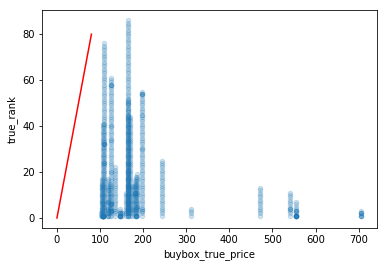

In [58]:
fig, ax = plt.subplots()
test1.plot(kind='scatter', x='buybox_true_price', y='true_rank', ax=ax, alpha=.2)
ax.plot([0,80],[0,80], 'r');

In [59]:
lr_rankprice.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Model shows that items that are not necessarily the cheapest are placed at the top of ranking order

<a id="Ensembles"></a>
### Ensembles

In [85]:
amazon.columns

Index(['Index', 'product', 'initial_rank', 'true_rank', 'initial_price',
       'true_price', 'vendor', 'initial_vendor_type', 'buybox_initial_price',
       'buybox_vendor_type', 'buybox_vendor', 'buybox_true_price'],
      dtype='object')

In [86]:
amazon.dtypes

Index                     int64
product                  object
initial_rank              int64
true_rank                 int64
initial_price           float64
true_price              float64
vendor                   object
initial_vendor_type      object
buybox_initial_price    float64
buybox_vendor_type       object
buybox_vendor            object
buybox_true_price       float64
dtype: object

In [87]:
# Transform "buybox_vendor_type" 
buybox_vendor_type_o_replace = {'Amazon':'1','O':'0','FBA':'2'}
amazon['buybox_vendor_type'].replace(buybox_vendor_type_o_replace, inplace = True)

In [88]:
buybox_vtype_data = pd.value_counts(amazon['buybox_vendor_type'].values)
buybox_vtype_data

amazon    5788
other      551
fba        470
dtype: int64

In [89]:
# Transform "buybox_vendor_type" 
amazon.loc[:, 'bb_vtype'] = amazon.loc[:, 'buybox_vendor_type'].map({'amazon': 1, 'other': 0, 'fba': 2})
amazon.drop('buybox_vendor_type', axis=1, inplace=True)

In [90]:
bb_vtype_data = pd.value_counts(amazon['bb_vtype'].values)
bb_vtype_data

1    5788
0     551
2     470
dtype: int64

In [91]:
initial_vtype = pd.value_counts(amazon['initial_vendor_type'].values)
initial_vtype

Other     6222
FBA        395
Amazon     192
dtype: int64

In [92]:
# Transform "initial_vendor_type" 
amazon.loc[:, 'bb_type_initial'] = amazon.loc[:, 'initial_vendor_type'].map({'Amazon': 1, 'Other': 0, 'FBA': 2})
amazon.drop('initial_vendor_type', axis=1, inplace=True)

In [93]:
bb_vtype_initial_data = pd.value_counts(amazon['bb_type_initial'].values)
bb_vtype_initial_data

0    6222
2     395
1     192
dtype: int64

In [94]:
amazon.head()

Index                                            product  \
ScrapeDate                                                             
2016-06-14      0  #1 BEST Probiotic Supplement - 60 Day Supply w...   
2016-06-14      1  #1 BEST Probiotic Supplement - 60 Day Supply w...   
2016-06-27      2  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27      3  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27      4  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   

            initial_rank  true_rank  initial_price  true_price  \
ScrapeDate                                                       
2016-06-14             2          1          20.99       20.99   
2016-06-14             1          2          19.99       25.02   
2016-06-27             1          1           3.96        3.96   
2016-06-27             1          1           3.96        3.96   
2016-06-27             1          1           3.96        3.96   

                         vendor  buybox_initial_price  \
ScrapeDate                                              
2016-06-14  Supplement Warriors                   0.0   
2016-06-14      Sharp Nutrition                   0.0   
2016-06-27         speedy tests                   4.9   
2016-06-27   Drug Abuse Control                   4.9   
2016-06-27  Lowest Priced Tests                   4.9   

                                               buybox_vendor  \
ScrapeDate                                                     
2016-06-14  Sold by Sharp Nutrition and Fulfilled by Amazon.   
2016-06-14  Sold by Sharp Nutrition and Fulfilled by Amazon.   
2016-06-27  Sold by Michael Minyety and Fulfilled by Amazon.   
2016-06-27  Sold by Michael Minyety and Fulfilled by Amazon.   
2016-06-27  Sold by Michael Minyety and Fulfilled by Amazon.   

            buybox_true_price  bb_vtype  bb_type_initial  
ScrapeDate                                                
2016-06-14              25.02         2                0  
2016-06-14              25.02         2                2  
2016-06-27               9.97         2                0  
2016-06-27               9.97         2                0  
2016-06-27               9.97         2                0

In [95]:
amazon.drop(['product', 'buybox_vendor', 'vendor'], axis=1, inplace=True)

In [96]:
amazon.loc[:,'buybox_initial_price'].replace([-1],0, inplace=True)
amazon.loc[:,'initial_price'].replace([-1],0, inplace=True)

In [97]:
amazon.head()

Index  initial_rank  true_rank  initial_price  true_price  \
ScrapeDate                                                              
2016-06-14      0             2          1          20.99       20.99   
2016-06-14      1             1          2          19.99       25.02   
2016-06-27      2             1          1           3.96        3.96   
2016-06-27      3             1          1           3.96        3.96   
2016-06-27      4             1          1           3.96        3.96   

            buybox_initial_price  buybox_true_price  bb_vtype  bb_type_initial  
ScrapeDate                                                                      
2016-06-14                   0.0              25.02         2                0  
2016-06-14                   0.0              25.02         2                2  
2016-06-27                   4.9               9.97         2                0  
2016-06-27                   4.9               9.97         2                0  
2016-06-27                   4.9               9.97         2                0

In [98]:
amazon.shape

(6809, 9)

In [99]:
# Set a seed for reproducibility.
np.random.seed(123)

In [100]:
np.random.choice(500)

365

In [101]:
nums = np.arange(6809)
np.random.choice(nums, size=6809, replace = True)

array([3454, 1346, 4060, ..., 3447, 4777, 2770])

In [102]:
nums = np.arange(6809)
samples = [np.random.choice(nums, size=6809, replace =True) for _ in range(10)] 
#for everything in range 10, give me a bootstrap sample
samples

[array([4620, 2546, 6642, ..., 6103, 2602,  727]),
 array([1044, 2882, 6611, ..., 1276, 3885, 4195]),
 array([ 719, 3413, 6466, ..., 2086, 3731,  512]),
 array([3602, 1923, 6543, ..., 1105, 1790, 5912]),
 array([3400, 4285,  826, ..., 2867, 6260, 5885]),
 array([1370,  855, 5866, ..., 3014, 1047, 6150]),
 array([2933, 3834,  596, ..., 4276, 5296, 4219]),
 array([6301,  495, 2265, ..., 1074, 6262, 6765]),
 array([2699, 1722, 1160, ..., 1046, 3123, 6318]),
 array([2618, 6003,  820, ..., 4282, 4370, 5366])]

In [103]:
# Show the rows for the first decision tree.
amazon.iloc[samples[0], :] #first list of indicies

Index  initial_rank  true_rank  initial_price  true_price  \
ScrapeDate                                                              
2016-06-07   4760            14         14          31.48       31.48   
2016-08-29   2571            12          8          12.98       12.98   
2016-06-08   6806            15         15         225.98      225.98   
2016-06-21    263            65         67         157.42      157.42   
2016-06-19     97             4          4          27.29       27.29   
2016-09-02    828             7          6           4.80        4.80   
2016-06-18    803             7          7          38.34       38.34   
2016-06-26   5820             1          2          47.99       53.47   
2016-06-29   3548            11         10          15.95       15.95   
2016-08-29   2578            17         13          13.88       13.88   
2016-06-14   1203            13         11          17.74       17.74   
2016-06-29   3541             7          6          14.69       14.69   
2016-06-14   2236             7          4          12.99       12.99   
2016-06-16   4389             8          8           6.28        6.28   
2016-06-28    142            23         23          24.56       24.56   
2016-08-30   2806             5          7           9.96       17.54   
2016-06-26   5273            42         49         104.95      104.95   
2016-06-17   3107            15         15          33.66       33.66   
2016-09-06   5192            12         12          17.82       17.82   
2016-09-02   6581             7          9          79.00       88.71   
2016-08-30   5154            11         22          30.57       36.93   
2016-06-20   4720            15         15          29.93       29.93   
2016-09-01   3087             3          1          48.44       48.44   
2016-06-17   3103            11         11          32.56       32.56   
2016-06-21     67            22         21          32.99       32.99   
2016-07-08   4132            14         14          15.20       15.20   
2016-06-17   1647            13         13         249.99      249.99   
2016-06-17   1410             5         22           7.55       14.22   
2016-06-13   3936             6          6          21.58       21.58   
2016-06-15   3848            14         13          49.94       49.94   
...           ...           ...        ...            ...         ...   
2016-06-18   6120             9          8          15.44       15.44   
2016-08-29   2585            22         19          14.52       14.52   
2016-06-27   3991            28         35          32.85       32.85   
2016-06-08   6802            13         12         225.08      225.08   
2016-08-30   5947            72         14          12.87       12.87   
2016-09-02   6087            11         11          41.72       41.72   
2016-06-08   1680             6          5         239.95      239.95   
2016-09-02    147             1          3          19.19       30.07   
2016-08-30   2361            22         21          18.54       18.54   
2016-06-24   1340            19         19         188.63      188.63   
2016-06-15   3891            57         45          71.93       71.93   
2016-08-29   1866            11         11         163.95      163.95   
2016-06-17   3098             7          6          31.53       31.53   
2016-09-02    828             7          6           4.80        4.80   
2016-09-02   4420            12         11          18.83       18.83   
2016-06-21   1918            30         35         160.08      160.08   
2016-06-26   4531             2          1          18.26       18.26   
2016-06-29    486            11         12          27.28       27.28   
2016-06-14   2546            47         47          69.98       69.98   
2016-06-14   2491             2          1          39.98       39.98   
2016-06-14   2267            34         33          21.51       21.51   
2016-06-15   3876            31         33          65.04       65.04 

In [143]:
# Read in and prepare the vehicle testing data.
url = '/Users/ginaadduci/Desktop/git-repo-practice/final_project_amazon-ranking-analysis/data/09-19-Amazon-Ranking-Analysis.csv'
test = pd.read_csv(url, parse_dates = True, index_col='ScrapeDate')
# Transform "buybox_vendor_type" 
test.loc[:, 'bb_vtype'] = test.loc[:, 'BBVendorType'].map({'Amazon': 1, 'O': 0, 'FBA': 2})
test.drop('BBVendorType', axis=1, inplace=True)
test.loc[:, 'bb_type_initial'] = test.loc[:, 'ScrapedIndexVendorType'].map({'Amazon': 1, 'O': 0, 'FBA': 2})
test.drop('ScrapedIndexVendorType', axis=1, inplace=True)
test

Index                                        ProductName  \
ScrapeDate                                                             
2016-06-14      0  #1 BEST Probiotic Supplement - 60 Day Supply w...   
2016-06-14      1  #1 BEST Probiotic Supplement - 60 Day Supply w...   
2016-06-27      2  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27      3  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27      4  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27      5  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27      6  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27      7  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27      8  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27      9  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27     10  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27     11  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27     12  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27     13  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27     14  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27     15  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27     16  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27     17  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27     18  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-20     19  2wayz FULL METAL BODY Garden Hose Splitter | Y...   
2016-06-20     20  2wayz FULL METAL BODY Garden Hose Splitter | Y...   
2016-08-29     21  3 Pair Motorcycle Riding Glasses Smoke Clear Y...   
2016-08-29     22  3 Pair Motorcycle Riding Glasses Smoke Clear Y...   
2016-08-29     23  3 Pair Motorcycle Riding Glasses Smoke Clear Y...   
2016-08-29     24  3 Pair Motorcycle Riding Glasses Smoke Clear Y...   
2016-08-29     25  3 Pair Motorcycle Riding Glasses Smoke Clear Y...   
2016-08-29     26  3 Pair Motorcycle Riding Glasses Smoke Clear Y...   
2016-08-29     27  3 Pair Motorcycle Riding Glasses Smoke Clear Y...   
2016-08-29     28  3 Pair Motorcycle Riding Glasses Smoke Clear Y...   
2016-08-29     29  3 Pair Motorcycle Riding Glasses Smoke Clear Y...   
...           ...                                                ...   
2016-09-06   6943   Zymox Otic Pet Ear Treatment with Hydrocortisone   
2016-09-06   6944   Zymox Otic Pet Ear Treatment with Hydrocortisone   
2016-09-06   6945   Zymox Otic Pet Ear Treatment with Hydrocortisone   
2016-09-06   6946   Zymox Otic Pet Ear Treatment with Hydrocortisone   
2016-09-06   6947   Zymox Otic Pet Ear Treatment with Hydrocortisone   
2016-09-06   6948   Zymox Otic Pet Ear Treatment with Hydrocortisone   
2016-09-06   6949   Zymox Otic Pet Ear Treatment with Hydrocortisone   
2016-09-06   6950   Zymox Otic Pet Ear Treatment with Hydrocortisone   
2016-09-06   6951   Zymox Otic Pet Ear Treatment with Hydrocortisone   
2016-09-06   6952   Zymox Otic Pet Ear Treatment with Hydrocortisone   
2016-09-06   6953   Zymox Otic Pet Ear Treatment with Hydrocortisone   
2016-09-06   6954   Zymox Otic Pet Ear Treatment with Hydrocortisone   
2016-09-06   6955   Zymox Otic Pet Ear Treatment with Hydrocortisone   
2016-09-06   6956   Zymox Otic Pet Ear Treatment with Hydrocortisone   
2016-06-26   6957  iPhone 6S Screen Protector, Maxboost Tempered ...   
2016-06-26   6958  iPhone 6S Screen Protector, Maxboost Tempered ...   
2016-08-30   6959                           myBaby SoundSpa Portable   
2016-08-30   6960                           myBaby SoundSpa Portable   
2016-08-30   6961                           myBaby SoundSpa Portable   
2016-08-30   6962                           myBaby SoundSpa Portable   
2016-08-30   6963                           myBaby SoundSpa Portable   
2016-08-30   6964                           myBaby SoundSpa Portable   
2016-08-30   6965                           myBaby S

In [144]:
test.rename(columns={'ScrapedIndexTrueRank':'initial_rank',
                       'CorrectedIndexTrueRank': 'true_rank', 'ScrapedIndexPrice' : 'initial_price',
                       'CorrectedPrice':'true_price','BBScrapedPrice':'buybox_initial_price',
                        'BBCorrectedPrice' : 'buybox_true_price'}, inplace =True)

In [145]:
test.columns

Index(['Index', 'ProductName', 'ScrapedIndex', 'initial_rank', 'true_rank',
       'initial_price', 'true_price', 'ScrapedIndexVendor',
       'buybox_initial_price', 'BBVendor', 'buybox_true_price', 'bb_vtype',
       'bb_type_initial'],
      dtype='object')

In [146]:
test.head()

Index                                        ProductName  \
ScrapeDate                                                             
2016-06-14      0  #1 BEST Probiotic Supplement - 60 Day Supply w...   
2016-06-14      1  #1 BEST Probiotic Supplement - 60 Day Supply w...   
2016-06-27      2  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27      3  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   
2016-06-27      4  10 Panel Dip Drug Testing Kit, Test for 10 Dif...   

            ScrapedIndex  initial_rank  true_rank  initial_price  true_price  \
ScrapeDate                                                                     
2016-06-14             2             2          1          20.99       20.99   
2016-06-14             1             1          2          19.99       25.02   
2016-06-27             1             1          1           3.96        3.96   
2016-06-27             2             1          1           3.96        3.96   
2016-06-27             3             1          1           3.96        3.96   

             ScrapedIndexVendor  buybox_initial_price  \
ScrapeDate                                              
2016-06-14  Supplement Warriors                  -1.0   
2016-06-14      Sharp Nutrition                  -1.0   
2016-06-27         speedy tests                   4.9   
2016-06-27   Drug Abuse Control                   4.9   
2016-06-27  Lowest Priced Tests                   4.9   

                                                    BBVendor  \
ScrapeDate                                                     
2016-06-14  Sold by Sharp Nutrition and Fulfilled by Amazon.   
2016-06-14  Sold by Sharp Nutrition and Fulfilled by Amazon.   
2016-06-27  Sold by Michael Minyety and Fulfilled by Amazon.   
2016-06-27  Sold by Michael Minyety and Fulfilled by Amazon.   
2016-06-27  Sold by Michael Minyety and Fulfilled by Amazon.   

            buybox_true_price  bb_vtype  bb_type_initial  
ScrapeDate                                                
2016-06-14              25.02         2              NaN  
2016-06-14              25.02         2              2.0  
2016-06-27               9.97         2              NaN  
2016-06-27               9.97         2              NaN  
2016-06-27               9.97         2              NaN

In [147]:
test.isnull().sum()

Index                      0
ProductName                0
ScrapedIndex               0
initial_rank               0
true_rank                  0
initial_price              0
true_price                 0
ScrapedIndexVendor         0
buybox_initial_price       0
BBVendor                 164
buybox_true_price          0
bb_vtype                   0
bb_type_initial         6372
dtype: int64

In [148]:
test.dropna(inplace = True)

In [149]:
test.drop(['ScrapedIndex', 'ProductName', 'ScrapedIndexVendor', 'BBVendor'], axis=1, inplace=True)

In [150]:
amazon.loc[:,'buybox_initial_price'].replace([-1],0, inplace=True)
amazon.loc[:,'initial_price'].replace([-1],0, inplace=True)

In [151]:
test.columns

Index(['Index', 'initial_rank', 'true_rank', 'initial_price', 'true_price',
       'buybox_initial_price', 'buybox_true_price', 'bb_vtype',
       'bb_type_initial'],
      dtype='object')

In [152]:
amazon.loc[:,'buybox_initial_price'].replace([-1],0, inplace=True)
amazon.loc[:,'initial_price'].replace([-1],0, inplace=True)

In [153]:
# Import decision tree regressor
from sklearn.tree import DecisionTreeRegressor

In [154]:
# Grow each tree deep.
treereg = DecisionTreeRegressor(max_depth=None, random_state = 222)

In [155]:
test.head()

Index  initial_rank  true_rank  initial_price  true_price  \
ScrapeDate                                                              
2016-06-14      1             1          2          19.99       25.02   
2016-06-27     11            10          7           4.79        9.86   
2016-06-27     12             2          8           4.90        9.97   
2016-08-29     27             2          7           8.97       15.54   
2016-08-29     28             2          7           8.97       15.54   

            buybox_initial_price  buybox_true_price  bb_vtype  bb_type_initial  
ScrapeDate                                                                      
2016-06-14                 -1.00              25.02         2              2.0  
2016-06-27                  4.90               9.97         2              2.0  
2016-06-27                  4.90               9.97         2              2.0  
2016-08-29                  6.79               6.79         0              2.0  
2016-08-29                  6.79               6.79         0              2.0

In [156]:
# Define testing data.
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

In [157]:
# Grow one tree for each bootstrap sample and make predictions on testing data.
predictions = [] #to build list

for sample in samples: #samples = list of array in rows 
    X_amazon = amazon.iloc[sample, 1:]
    y_amazon = amazon.iloc[sample, 0]
    treereg.fit(X_amazon, y_amazon)
    y_pred = treereg.predict(X_test)
    predictions.append(y_pred)

In [158]:
predictions

[array([  5.82500000e+03,   1.10000000e+01,   3.00000000e+00,
          2.60000000e+01,   2.60000000e+01,   2.90000000e+01,
          4.20000000e+01,   4.90000000e+01,   5.20000000e+01,
          5.60000000e+01,   5.70000000e+01,   8.50000000e+01,
          9.40000000e+01,   1.11000000e+02,   1.14000000e+02,
          1.15000000e+02,   1.15000000e+02,   1.33000000e+02,
          1.47000000e+02,   1.56000000e+02,   1.56000000e+02,
          1.60000000e+02,   1.91000000e+02,   2.41000000e+02,
          2.74000000e+02,   2.74000000e+02,   2.76000000e+02,
          2.76000000e+02,   2.76000000e+02,   2.82000000e+02,
          2.91000000e+02,   3.05000000e+02,   3.16000000e+02,
          3.18000000e+02,   3.20000000e+02,   3.72000000e+02,
          3.76500000e+02,   3.76500000e+02,   3.76500000e+02,
          3.80000000e+02,   3.82000000e+02,   3.83000000e+02,
          3.84000000e+02,   3.85000000e+02,   3.90000000e+02,
          4.36000000e+02,   4.43000000e+02,   4.49000000e+02,
        

In [159]:
# Convert predictions from list to NumPy array.
#Make it a single array

np.array(predictions)

array([[  5.82500000e+03,   1.10000000e+01,   3.00000000e+00, ...,
          6.96200000e+03,   6.96500000e+03,   6.97100000e+03],
       [  5.82500000e+03,   1.10000000e+01,   1.20000000e+01, ...,
          6.96300000e+03,   6.96400000e+03,   6.96400000e+03],
       [  5.82500000e+03,   1.10000000e+01,   1.20000000e+01, ...,
          6.96300000e+03,   6.96400000e+03,   6.97100000e+03],
       ..., 
       [  5.82500000e+03,   1.10000000e+01,   1.10000000e+01, ...,
          6.96000000e+03,   6.96100000e+03,   6.96900000e+03],
       [  5.76900000e+03,   1.10000000e+01,   1.20000000e+01, ...,
          6.96100000e+03,   6.96500000e+03,   6.97100000e+03],
       [  1.00000000e+00,   1.00000000e+01,   1.20000000e+01, ...,
          6.96000000e+03,   6.96500000e+03,   6.97100000e+03]])

In [160]:
#overwrite predictions

predictions = np.array(predictions)
predictions 

array([[  5.82500000e+03,   1.10000000e+01,   3.00000000e+00, ...,
          6.96200000e+03,   6.96500000e+03,   6.97100000e+03],
       [  5.82500000e+03,   1.10000000e+01,   1.20000000e+01, ...,
          6.96300000e+03,   6.96400000e+03,   6.96400000e+03],
       [  5.82500000e+03,   1.10000000e+01,   1.20000000e+01, ...,
          6.96300000e+03,   6.96400000e+03,   6.97100000e+03],
       ..., 
       [  5.82500000e+03,   1.10000000e+01,   1.10000000e+01, ...,
          6.96000000e+03,   6.96100000e+03,   6.96900000e+03],
       [  5.76900000e+03,   1.10000000e+01,   1.20000000e+01, ...,
          6.96100000e+03,   6.96500000e+03,   6.97100000e+03],
       [  1.00000000e+00,   1.00000000e+01,   1.20000000e+01, ...,
          6.96000000e+03,   6.96500000e+03,   6.97100000e+03]])

In [161]:
# Average predictions.
#axis = 0 means go down the rows
np.mean(predictions, axis = 0)

array([ 4648.9       ,    11.4       ,    10.9       ,    26.9       ,
          26.9       ,    28.        ,    42.3       ,    49.1       ,
          51.65      ,   604.6       ,    55.8       ,    86.2       ,
          94.8       ,   111.4       ,   114.2       ,   114.7       ,
         115.8       ,   132.        ,   147.2       ,   157.3       ,
         157.7       ,   159.        ,   191.1       ,   238.9       ,
         274.4       ,   274.8       ,   277.6       ,   278.8       ,
         279.1       ,   282.9       ,   290.7       ,   304.7       ,
         316.2       ,   317.9       ,   320.5       ,  2667.27222222,
         375.89333333,   375.89333333,   375.89333333,   379.6       ,
         381.9       ,   382.6       ,   383.7       ,   385.2       ,
         388.5       ,   436.6       ,   479.7       ,   447.9       ,
         451.1       ,   462.        ,   463.2       ,   983.4       ,
         511.        ,   512.425     ,   512.425     ,   516.2       ,
      

In [162]:
from sklearn import metrics

y_pred = np.mean(predictions, axis = 0)
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

289.76598518758794

In [163]:
#OR....

y_pred = np.mean(predictions, axis=0)
metrics.mean_absolute_error(y_test, y_pred)

53.580930139801517

This means that our prediction is $53 off

<a id="LR #2"></a>
### LR #2

In [53]:
from sklearn.linear_model import LinearRegression

In [64]:
lr = LinearRegression()

X = amazon.loc[:, ['Vendor_Type']]
y = amazon.loc[:, 'Initial_Rank']

lr.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [65]:
amazon.loc[:, 'prediction'] = lr.predict(X)

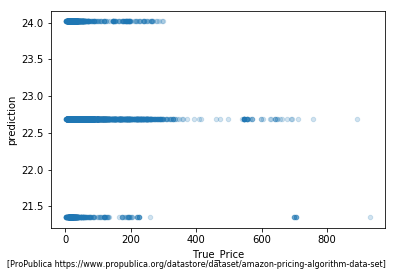

In [66]:
fig, ax = plt.subplots()
amazon.plot(kind = 'scatter', x = 'True_Price', y='prediction', ax=ax, alpha=0.2);

plt.annotate('[ProPublica https://www.propublica.org/datastore/dataset/amazon-pricing-algorithm-data-set]', 
             (-0.1,-0.1), (-10,-10), fontsize=8, xycoords='axes fraction', textcoords='offset points', va='top');

In [58]:
lr = LinearRegression()

X = amazon.loc[:, ['Vendor_True_Price']]
y = amazon.loc[:, 'True_Price']

lr.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [59]:
amazon.loc[:, 'prediction'] = lr.predict(X)

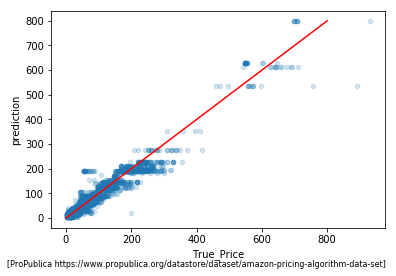

In [60]:
fig, ax = plt.subplots()
amazon.plot(kind = 'scatter', x = 'True_Price', y='prediction', ax=ax, alpha=0.2)
ax.plot([0, 800], [0, 800], 'r');

plt.annotate('[ProPublica https://www.propublica.org/datastore/dataset/amazon-pricing-algorithm-data-set]', 
             (-0.1,-0.1), (-10,-10), fontsize=8, xycoords='axes fraction', textcoords='offset points', va='top');

In [ ]:
sns.lmplot(x='fuel_eco_score', y='combi_mpg_1', data=fuel_economy,
          col='FT1', hue='FT1');

<a id="Conclusion"></a>
### Conclusion

I was not able to prove the algorithm is inaccurate, however I did find a correlation between the ranking order and true price. Additionally, predictions showed that Amazon places their products typically higher within the ranking scale. 

To examine even further and accurately predict my hypothesis I will need to work with a smaller sample size and potentially look at the data on a product by product basis or randomly select a small sample group.

<a id="Next Steps"></a>
### Next Steps

1) Look at a smaller sample size and continue to test if price and ranking order correlate

2) If possible, look at products by various vendor (hoping to find a product that was purchased through Amzazon versus other products)